In [1]:
# # Install necessary packages
# !pip install xgboost
# !pip install optuna

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
)

from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import shap
import optuna

# Global Configuration
base_dir = Path().resolve().parent

TUNE_MODE = True # Enable Optuna tuning
N_TRIALS = 20 # Number of trial for Optuna
SEED = 42

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

TUNE_MODE: ON | Optuna Trials: 20


In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_flux = pd.read_csv("/content/drive/MyDrive/Data/dataset/csv/fluxomics.csv", index_col=0)

In [ ]:
#  Step 2: Prepare data for ML models

#  2.1 Select the top features and remove Exchange reactions

# Remove exchange reaction
rxns = [c for c in df_flux.columns if c != "response" and not c.startswith("EX_")]
flux = df_flux[rxns]

# Number of top flux features to retain by variance
fl_n = 200
fl_top = flux.var().sort_values(ascending=False).index[:fl_n]

# Build the feature matrix (X) using the selected top fluxes
X = flux[fl_top]

# Extract target column
y = df_flux['response']

#  2.2 Encode target variable
# Convert categorical response labels to numeric (binary classification)
# 'Responder' -> 1, 'Non-responder' -> 0
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)

print(X.shape)

(51831, 200)


In [ ]:
# 2.3 Split the data into training and test sets
# Split dataset into training and test sets (80% train, 20% test)
# Stratified split ensures class balance is preserved in both subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)

# 2.4 Standardize the features
scaler = StandardScaler()

# Fit the scaler only on the training data to avoid data leakage
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to validation and test sets
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Step 3: Optuna for Hyper-parameter tunning

# 3.1 Optuna Objective Functions with class balance

# Compute class balance ratio
def class_balance(y):
    """
    Compute class imbalance ratio for weighting.
    Returns ratio (negative_count / positive_count).
    Used to compensate for imbalance in binary classification.
    """
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression Objective Function
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Logistic Regression using Optuna.
    Hyperparameter: Regularization strength (C).
    """
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest Objective Function
def tune_rf(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning Random Forest using Optuna.
    Tuned hyperparameters include depth, splits, and max features.
    """
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost Objective Function
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning XGBoost using Optuna.
    Includes learning rate, depth, and subsampling parameters.
    """
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Artificial Neural Network (ANN) Objective Function
def tune_ann(trial, X_train, X_val, y_train, y_val):
    """
    Objective function for tuning a simple feed-forward ANN using Optuna.
    The model adapts to class imbalance via sample weighting.
    """
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)

[I 2025-10-17 22:55:03,608] A new study created in memory with name: no-name-5a62c134-b624-4a0c-ad73-aa08231181b8


Class balance ratio: neg/pos = 1.97


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-17 22:55:07,319] Trial 0 finished with value: 0.5564147154663764 and parameters: {'C': 1.0002274288627326}. Best is trial 0 with value: 0.5564147154663764.
[I 2025-10-17 22:55:10,164] Trial 1 finished with value: 0.5560011254858054 and parameters: {'C': 0.15921048026378148}. Best is trial 0 with value: 0.5564147154663764.
[I 2025-10-17 22:55:11,161] Trial 2 finished with value: 0.552741450248382 and parameters: {'C': 0.0028141926318399446}. Best is trial 0 with value: 0.5564147154663764.
[I 2025-10-17 22:55:15,354] Trial 3 finished with value: 0.5557605919742702 and parameters: {'C': 0.05488228011973542}. Best is trial 0 with value: 0.5564147154663764.
[I 2025-10-17 22:55:18,558] Trial 4 finished with value: 0.5559208825163466 and parameters: {'C': 0.09434400158221365}. Best is trial 0 with value: 0.5564147154663764.
[I 2025-10-17 22:55:22,398] Trial 5 finished with value: 0.5565088316115615 and parameters: {'C': 7.111806183068763}. Best is trial 5 with value: 0.556508831611

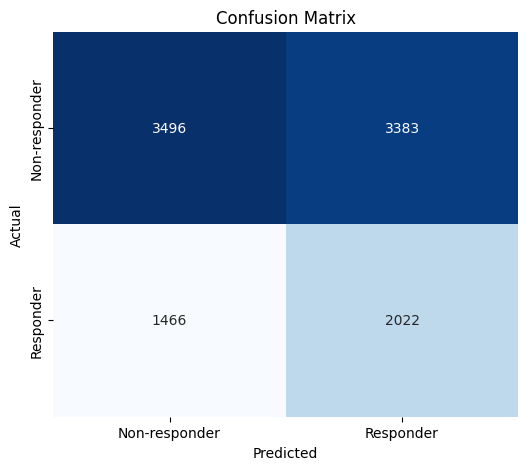

In [ ]:
#  3.2 Run hyperparameter tuning and evaluation for Logistic Regression (LR)

# Step 1: Compute class balance
w = class_balance(y_train)
print(f"Class balance ratio: neg/pos = {w:.2f}")

# Step 2: Define and run Optuna study
name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study.best_value:.3f} | params={study.best_params}")


# Step 3: Refit model on the full training set by best parameters which obtains by Optuna
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )
model_lr.fit(X_train, y_train)

# Step 4: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred = model_lr.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

#  Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-17 22:56:26,467] A new study created in memory with name: no-name-98145406-d17a-4cc3-a938-0d520da7e5bb


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-17 22:58:44,659] Trial 0 finished with value: 0.5928699041317964 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5928699041317964.
[I 2025-10-17 23:02:04,710] Trial 1 finished with value: 0.5961866352468546 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5961866352468546.
[I 2025-10-17 23:04:02,544] Trial 2 finished with value: 0.595518964240424 and parameters: {'n_estimators': 400, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5961866352468546.
[I 2025-10-17 23:05:45,106] Trial 3 finished with value: 0.5947347715843492 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.5961866352468546.

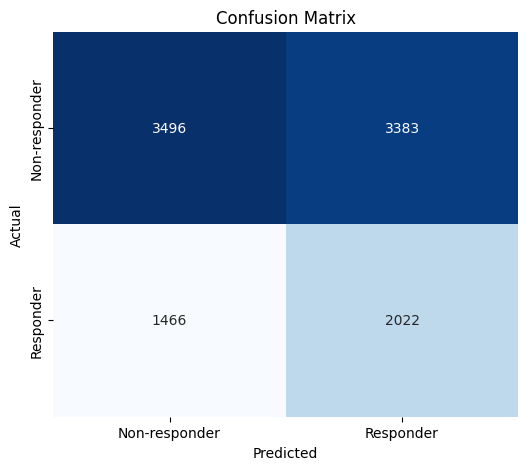

In [ ]:
#  3.3 Run hyperparameter tuning and evaluation for Random Forest (RF)

# Step 1: Define and run Optuna study
name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})
model_rf.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_rf = model_lr.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_rf = model_lr.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-17 23:40:21,763] A new study created in memory with name: no-name-b92e8140-b8d2-45d0-9391-aadea4c498f5


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-17 23:41:58,143] Trial 0 finished with value: 0.5703338745825836 and parameters: {'learning_rate': 0.10278198855828134, 'max_depth': 10, 'subsample': 0.8987814332980459, 'colsample_bytree': 0.8941615625332792, 'n_estimators': 400}. Best is trial 0 with value: 0.5703338745825836.
[I 2025-10-17 23:42:17,803] Trial 1 finished with value: 0.5998587932160822 and parameters: {'learning_rate': 0.010572042417321341, 'max_depth': 5, 'subsample': 0.9429516810739187, 'colsample_bytree': 0.8195833928184089, 'n_estimators': 400}. Best is trial 1 with value: 0.5998587932160822.
[I 2025-10-17 23:45:57,985] Trial 2 finished with value: 0.575726306341865 and parameters: {'learning_rate': 0.01781215564105831, 'max_depth': 11, 'subsample': 0.9706602647939402, 'colsample_bytree': 0.6356649712054216, 'n_estimators': 800}. Best is trial 1 with value: 0.5998587932160822.
[I 2025-10-17 23:46:08,870] Trial 3 finished with value: 0.6004217966479021 and parameters: {'learning_rate': 0.0198641616755283

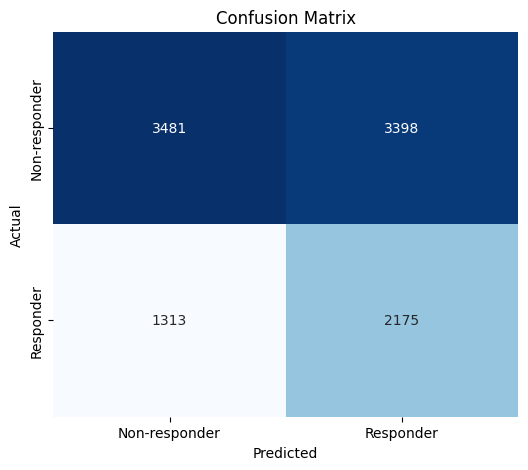

In [ ]:
#  3.4 Run hyperparameter tuning and evaluation for XGBoost (XGB)

# Step 1: Define and run Optuna study
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"{name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)
model_gb.fit(X_train, y_train)

# Step 3: Evaluate on test data
# Probability predictions for ROC/AUC
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
# Binary predictions using default 0.5 threshold
y_pred_gb = model_gb.predict(X_test)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-17 23:58:26,001] A new study created in memory with name: no-name-78acd378-a8d9-456f-a63a-ead2f8450848


  0%|          | 0/20 [00:00<?, ?it/s]

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-17 23:58:53,971] Trial 0 finished with value: 0.5691873836167565 and parameters: {'lr': 0.0011382459752298244, 'dropout': 0.4418522400395739, 'n1': 96, 'n2': 48}. Best is trial 0 with value: 0.5691873836167565.
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-17 23:59:41,130] Trial 1 finished with value: 0.5621742327580199 and parameters: {'lr': 0.00020944943213162194, 'dropout': 0.48882123183112863, 'n1': 128, 'n2': 64}. Best is trial 0 with value: 0.5691873836167565.
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[I 2025-10-18 00:00:29,678] Trial 2 finished with value: 0.5711658417663353 and parameters: {'lr': 0.000553053166005403, 'dropout': 0.5094494834690588, 'n1': 32, 'n2': 16}. Best is trial 2 with value: 0.5711658417663353.
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[I 2025-10-18 00:01:02,715] Trial 3 finished with value: 0.5683113544453107 and parameters: {'lr': 0.0003711570478928205, 'dropout': 0.35359402429823417, 'n1': 96, 'n2'

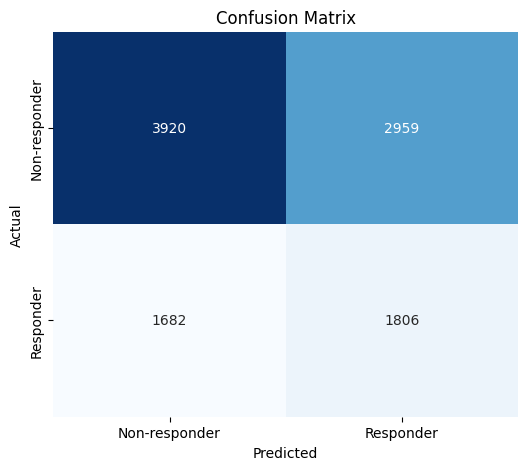

In [ ]:
#  3.5 Run hyperparameter tuning and evaluation for ANN

# Step 1: Define and run Optuna study
name = 'ANN'
study_ann = optuna.create_study(direction="maximize")
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"{name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# Step 2: Refit model on the full training set by best parameters which obtains by Optuna

# Retrieve best hyperparameters from the ANN Optuna study
best_params = study_ann.best_params

# Compute class imbalance ratio for weighting
w = class_balance(y_train)

#  Build ANN architecture
ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile model
ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define early stopping to avoid overfitting
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Handle class imbalance via per-sample weighting
sample_weights = np.where(y_train == 1, w, 1)

# Train model
ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# Step 3: Evaluate on test data

# Probability predictions for ROC/AUC
y_prob_ann = ann.predict(X_test)
# Binary predictions using default 0.5 threshold
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


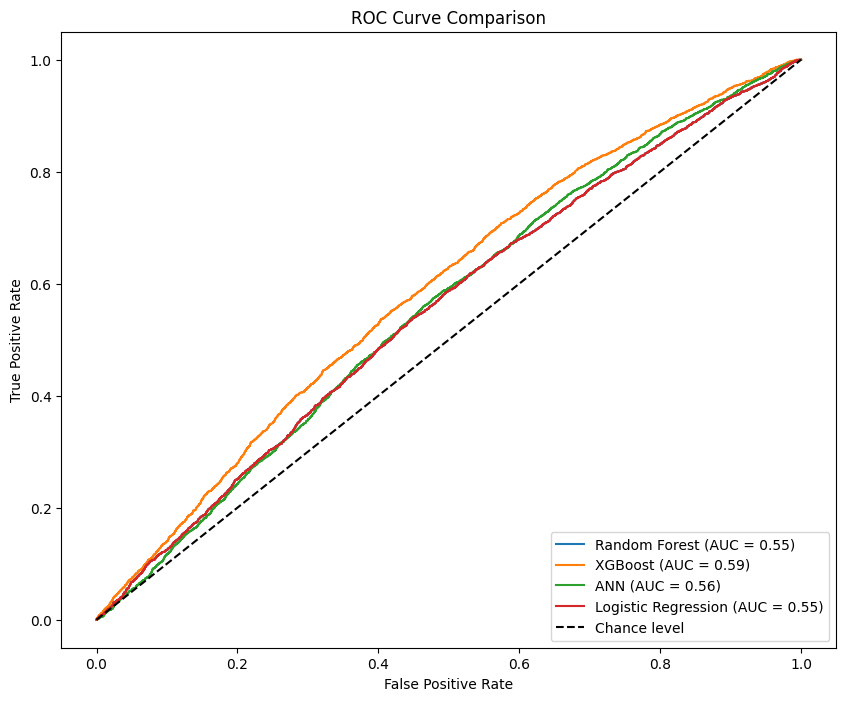

In [ ]:
# Model Comparsion - ROC Curve

# Compute ROC and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Compute F1 Macro for all models
f1_logreg = f1_score(y_test, y_pred, average='macro')
f1_xgb    = f1_score(y_test, y_pred_gb, average='macro')
f1_rf     = f1_score(y_test, y_pred_rf, average='macro')
f1_ann    = f1_score(y_test, y_pred_ann, average='macro')

# Display results
print(f"F1 Macro - Logistic Regression: {f1_logreg:.4f}")
print(f"F1 Macro - XGBoost: {f1_xgb:.4f}")
print(f"F1 Macro - Random Forest: {f1_rf:.4f}")
print(f"F1 Macro - ANN: {f1_ann:.4f}")

F1 Macro - Logistic Regression: 0.5226
F1 Macro - XGBoost: 0.5382
F1 Macro - Random Forest: 0.5226
F1 Macro - ANN: 0.5329


In [ ]:
# Compute Brier scores (lower = better)
brier_logreg = brier_score_loss(y_test, y_prob)
brier_xgb    = brier_score_loss(y_test, y_prob_gb)
brier_rf     = brier_score_loss(y_test, y_prob_rf)
brier_ann    = brier_score_loss(y_test, y_prob_ann)

# Display results
print(f"Brier Score - Logistic Regression: {brier_logreg:.4f}")
print(f"Brier Score - XGBoost: {brier_xgb:.4f}")
print(f"Brier Score - Random Forest: {brier_rf:.4f}")
print(f"Brier Score - ANN: {brier_ann:.4f}")

Brier Score - Logistic Regression: 0.2446
Brier Score - XGBoost: 0.2430
Brier Score - Random Forest: 0.2483
Brier Score - ANN: 0.2446


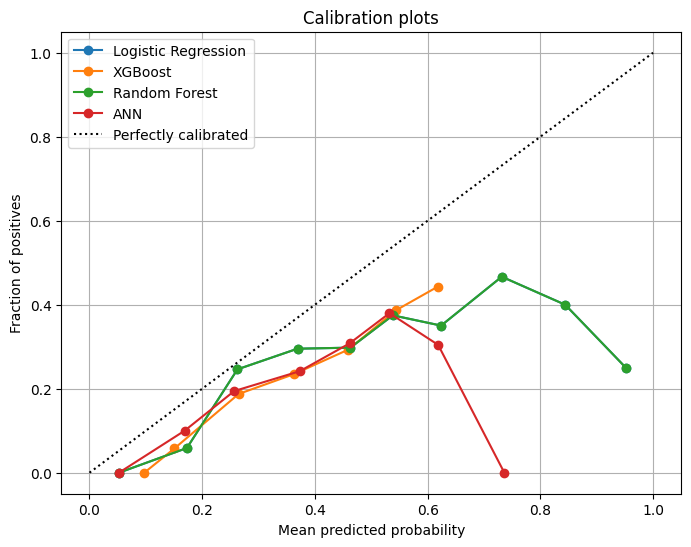

In [ ]:
# Calibration Curver Comparison

# Initialize plot
plt.figure(figsize=(8, 6))

# Define models and their predicted probabilities
for model_name, y_prob in [
    ('Logistic Regression', y_prob),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

# Plot
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation using Matthews Correlation Coefficient (MCC)

# Define threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary classes
y_pred_logreg = (y_prob > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Compute MCC for each model
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.0831
MCC - XGBoost: 0.1228
MCC - Random Forest: 0.0832
MCC - ANN: 0.0831


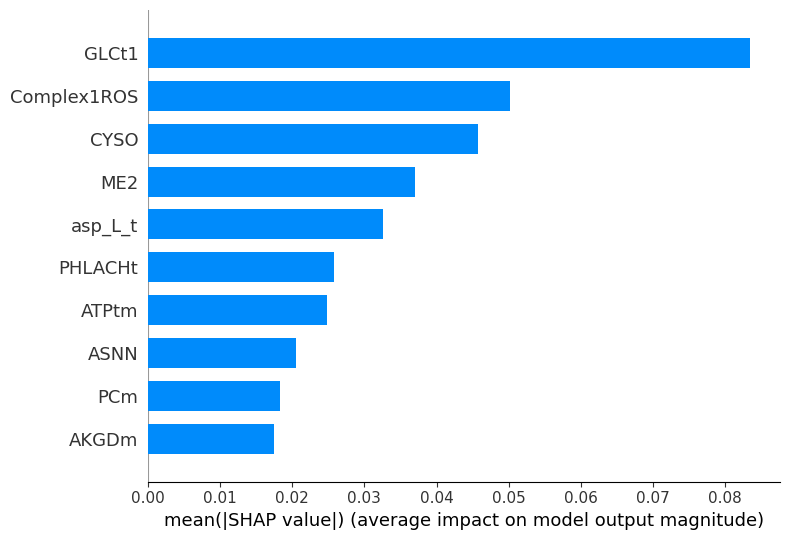

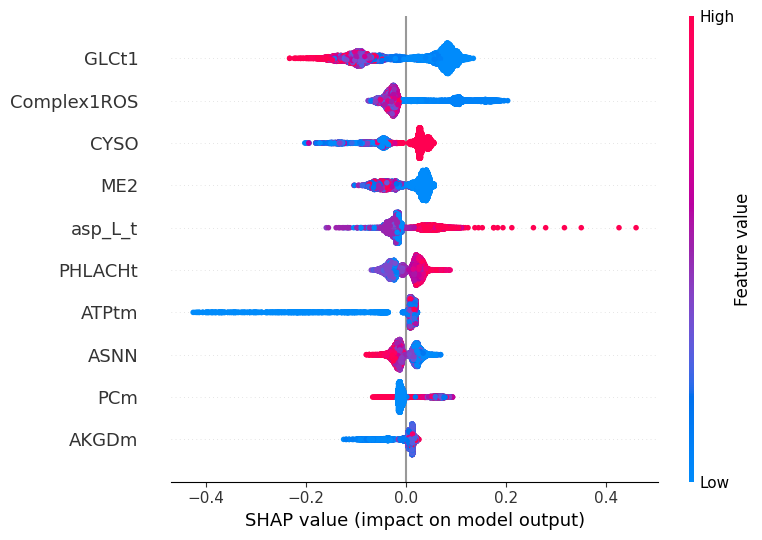

In [ ]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)